# Example of training the model for different dataset

- 
- This is using fastai (https://github.com/fastai/fastai) lib ver 0.7


## Setup

In [1]:
%matplotlib inline
%load_ext autoreload
# use %autoreload command to reload all libraries

In [2]:
from IPython.core.debugger import set_trace
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last_expr"

In [3]:
# Python path fixing so we can import libraries
import sys
import os
sys_paths = ['../', # Adding yolov3_pytorch to python paths
            '../../hands/fastai', # Fastai lib to help data handling etc: https://github.com/fastai/fastai
            '../../../data/coco/cocoapi/PythonAPI',
            ]
for p in sys_paths:
    p = os.path.abspath(p)
    if p not in sys.path:
        sys.path.append(p)

In [4]:
import time
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from matplotlib import patches, patheffects

In [5]:
print("Pytorch: {}".format(torch.__version__))

Pytorch: 0.4.0


In [6]:
from yolov3_pytorch.utils import *
from yolov3_pytorch.yolov3 import *
from yolov3_pytorch.yolov3_tiny import *

In [7]:
from voc_utils import *
from yolov3_pytorch.fastai_utils import *

In [8]:
%autoreload

# Dataset

In [9]:
data_filenames = ["../../../data/voc/2007_train.txt", "../../../data/voc/2007_val.txt"]
#md = get_voc_md(data_filenames=data_filenames, sz=416, data_max_lines=[10*32, 5*32])
md = get_voc_md(data_filenames=data_filenames, sz=416)

In [10]:
batch_x, batch_y = next(iter(md.trn_dl))

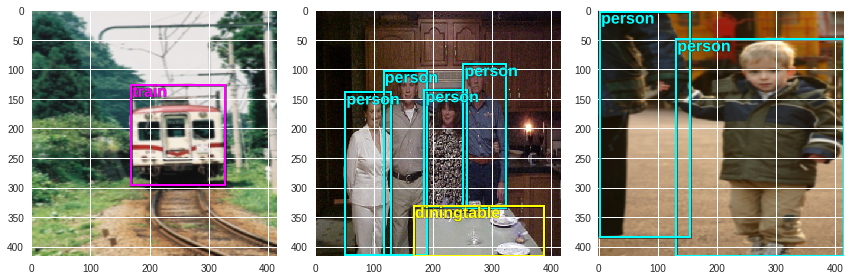

In [11]:
plot_img_data(batch_x, batch_y, rows=1, class_names=VocDataset.CLASS_NAMES)

# Model

In [12]:
%autoreload

In [13]:
# model = Yolov3Tiny(num_classes=len(VocDataset.CLASS_NAMES))
# model.load_backbone('../data/models/yolov3_tiny_coco_01.h5')

In [14]:
model = Yolov3(num_classes=len(VocDataset.CLASS_NAMES))
model.load_backbone('../data/models/yolov3_coco_01.h5')[0]

In [15]:
model.freeze_backbone()
model.freeze_info()
_ = model.cuda()

Layer: param.requires_grad
backbone :  {False}
yolo_0_pre :  {True}
yolo_1_c :  {True}
yolo_1_prep :  {True}
yolo_2_c :  {True}
yolo_2_prep :  {True}


# Training

In [16]:
sz = 416

yolo_loss = YoloLoss(model)
yolo_loss_metrics = YoloLossMetrics(yolo_loss)
learn = YoloLearner(md, model,
                    models_name=os.path.abspath("data/models"),
                    clip=1000,
                    crit=yolo_loss,
                    metrics=(yolo_loss_metrics.layer_losses() + yolo_loss_metrics.individual_losses()))

In [17]:
%%time
_ = learn.fit(0.0001, n_cycle=2, cycle_len=1)

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   yolo_l_0   yolo_l_1   yolo_l_2   loss_coord loss_conf  loss_cls   
    0      2599.595633 536.539525 130.2954   177.676108 227.552894 49.209668  237.194767 249.119965
    1      774.535725 351.505159 101.10626  115.116825 134.407493 41.557753  224.778935 84.29389  

CPU times: user 11min 37s, sys: 2min 46s, total: 14min 23s
Wall time: 3min 21s


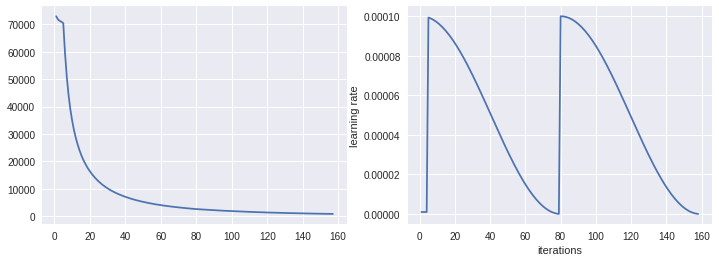

In [18]:
learn_sched_plot(learn)

In [19]:
%%time
_ = learn.fit(0.0001, n_cycle=1, cycle_len=4)

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   yolo_l_0   yolo_l_1   yolo_l_2   loss_coord loss_conf  loss_cls   
    0      364.083533 375.173029 101.068125 122.568767 150.599146 68.164183  210.667726 95.40413  
    1      289.864714 288.888056 77.512504  95.057305  116.579759 36.78437   193.84676  58.518437 
    2      238.126285 268.858391 71.959029  84.814622  110.349435 29.435249  186.8125   50.875336 
    3      212.581236 264.3302   71.214724  83.464923  108.442713 28.184365  185.33262  49.605375 

CPU times: user 23min 24s, sys: 5min 34s, total: 28min 59s
Wall time: 6min 51s


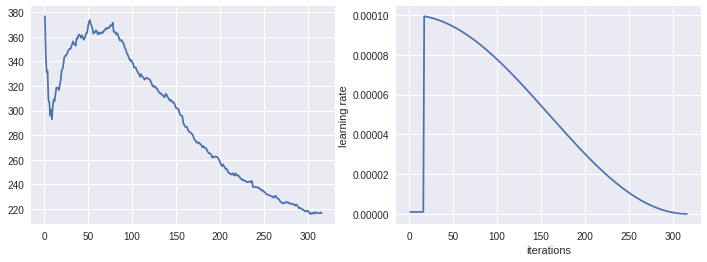

In [20]:
learn_sched_plot(learn)

In [21]:
%%time
_ = learn.fit(0.00001, n_cycle=2, cycle_len=4)

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   yolo_l_0   yolo_l_1   yolo_l_2   loss_coord loss_conf  loss_cls   
    0      207.223265 263.871787 70.881774  83.181349  108.286503 28.106189  183.789828 50.453607 
    1      201.990277 263.280469 70.967605  83.021753  107.935882 28.091074  182.866491 50.967674 
    2      196.465711 261.973445 70.697908  82.618647  107.233454 27.795044  181.946038 50.808927 
    3      196.564659 261.929865 70.73142   82.59561   107.210295 27.774537  181.887146 50.875644 
    4      193.078741 262.205206 70.751986  82.482259  107.216371 27.881298  181.239413 51.329905 
    5      191.497111 261.26305  70.504382  82.234906  106.986817 27.626155  180.184135 51.915814 
    6      187.459019 260.955388 70.468225  82.155677  106.823965 27.415     179.746287 52.28658  
    7      186.843912 261.028528 70.501921  82.197459  106.840967 27.383575  179.868434 52.288338 

CPU times: user 47min 40s, sys: 11min 15s, total: 58min 56s
Wall time: 14min 24s


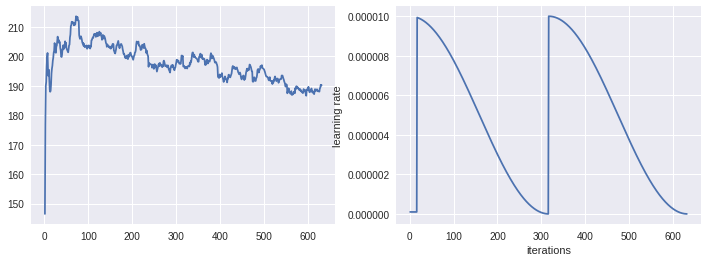

In [22]:
learn_sched_plot(learn)

# Manual Test

In [23]:
batch_x, batch_y = next(iter(md.val_dl))

In [24]:
preds = model.predict_img(batch_x)

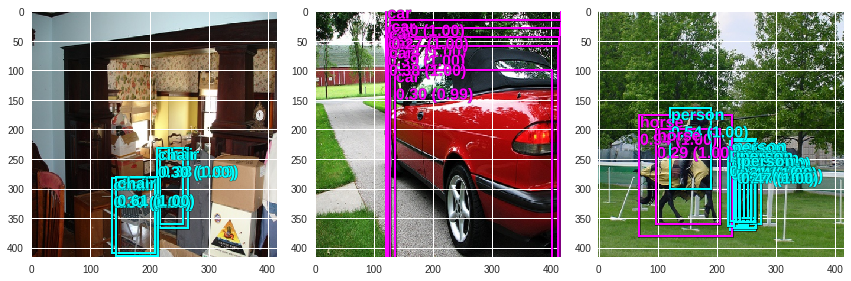

In [25]:
plot_multi_detections(batch_x[:3], preds, class_names=VocDataset.CLASS_NAMES)

In [26]:
preds_nms = [nms(p, nms_thresh=.4) for p in preds]

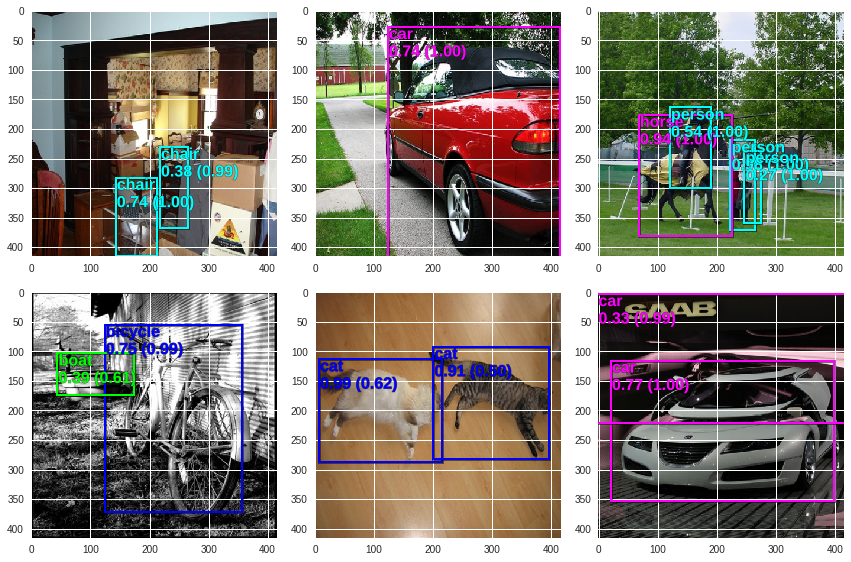

In [27]:
plot_multi_detections(batch_x[:6], preds_nms, class_names=VocDataset.CLASS_NAMES)

# Evaluate